In [1]:
from pyspark.sql.functions import udf, size, avg, count, col,sum, explode
import json
from datetime import datetime,timedelta
env = "production"
# env = "staging"
# 
s3_mobile_client_bucket = "s3://mist-secorapp-{env}/mobile-client-marvis/mobile-client-marvis-{env}/".format(env=env)

now = datetime.now()  - timedelta(hours=3)
date_day = now.strftime("%Y-%m-%d")
date_hour = now.strftime("%H")


#date_day = "2021-03-*"
#date_hour = "*"

date_day = "2021-04-*"
date_hour = "*"

s3_mobile_client_path = s3_mobile_client_bucket + "dt={date}/{hr}/*.seq".format(date=date_day, hr=date_hour)
print(s3_mobile_client_path)

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
90,application_1618773637871_0099,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://mist-secorapp-production/mobile-client-marvis/mobile-client-marvis-production/dt=2021-04-*/*/*.seq

In [2]:
rdd_mobile_client = spark.sparkContext.sequenceFile(s3_mobile_client_path)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from datetime import datetime as dt

def EpochTime():
    # Unix time 
    return( dt(1970, 1, 1) )

def TimeSinceEpoch( ts ):
    # Seconds since Epoch
    return( int((dt.strptime(ts, "%Y-%m-%dT%H:%M:%S.%fZ") - EpochTime()).total_seconds()) )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# used to ignore BSSID change if time gap between current and prior events is more than TIME_GAP
TIME_GAP = 3

def DetectRoamingEvent( rawdata ): 
    # 
    # Detect event in Tests temporal sequence where current BSSID is different than prior BSSID
    #
    decoded_rawdata=rawdata[1].decode()
    data=json.loads(decoded_rawdata) 

    try:
        nreadings = len( data['Result']['Stats']['Passive']['Tests'] )
        tests = data['Result']['Stats']['Passive']['Tests']
        BSSID_change = False
        if( nreadings > 1 ):
            date = str(data['Result']['Stats']['Passive']['Tests'][0]['Timestamp'])
            Start_TimeSinceEpoch = int((dt.strptime(date, "%Y-%m-%dT%H:%M:%S.%fZ") - EpochTime()).total_seconds())
            for i in range(1, nreadings):
                prevTime = TimeSinceEpoch( str(tests[i-1]['Timestamp'])) - Start_TimeSinceEpoch
                currTime = TimeSinceEpoch( str(tests[i]['Timestamp'])) - Start_TimeSinceEpoch

                if ( ( tests[i-1]['WiFiConnectionData']['BSSID'] != tests[i]['WiFiConnectionData']['BSSID'] ) and
                    ( currTime - prevTime <= TIME_GAP ) 
                    ):
                    BSSID_change = True or BSSID_change
                else:
                    BSSID_change = False or BSSID_change                 
    except ( KeyError, TypeError ):
        pass

    return( BSSID_change )
    
def RoamingEvents(a):
    ok = DetectRoamingEvent(a)
    return(ok)

def FindSpecificEvents( rawdata ): 
    start_ts = 0
    end_ts = 1
    start_ts = 1617748240
    end_ts = 1617748241
    
    decoded_rawdata=rawdata[1].decode()
    data=json.loads(decoded_rawdata) 

    try:
        found = False
        nreadings = len( data['Result']['Stats']['Passive']['Tests'] )
        if( nreadings > 0 ):
            if( data['Result']['Stats']['Passive']['Tests'][0] != None and data['Result']['Stats']['Passive']['Tests'][nreadings-1] != None ):
                first_ts = TimeSinceEpoch( str(data['Result']['Stats']['Passive']['Tests'][0]['Timestamp']))
                last_ts = TimeSinceEpoch( str(data['Result']['Stats']['Passive']['Tests'][nreadings-1]['Timestamp']))             
                if( first_ts <= start_ts and last_ts >= end_ts ):
                    found = True
                else:
                    found = False
            else:
                found = False
        else:
            found = False
    except ( KeyError, IndexError, TypeError ):
        found = False
        
    return found

def SpecificEvents(a):
    ok = FindSpecificEvents( a )
    return( ok )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# for debugging purposes
#import pprint
#rddSpecificTests = rdd_mobile_client.filter(SpecificEvents)
#rddSpecificTestsCount = rddSpecificTests.count()
#print( "# Specific Tests: " + str( rddSpecificTestsCount ) )
#if( rddSpecificTestsCount > 0 ):
#    data_Specific = rddSpecificTests.take(rddSpecificTestsCount)
#    for i in range( rddSpecificTestsCount ):
#        pprint.pprint( json.loads( data_Specific[i][1] ) )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#
# RDD Filter tests (test sequences) that contain roaming event(s)
#
rddRoamingTests = rdd_mobile_client.filter(RoamingEvents)
rddRoamingTestsCount = rddRoamingTests.count()
print( "# Roaming Tests: " + str( rddRoamingTestsCount ) )
# Get Filtered Events
if( rddRoamingTestsCount > 0 ):
    data_Roaming = rddRoamingTests.take(rddRoamingTestsCount)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Roaming Tests: 10727

In [7]:
import pandas as pd
from datetime import datetime as dt
import pprint
import os

NEXT_N=5

BAD_THRESHOLD=-75
GOOD_THRESHOLD=-60

LARGE_CHANGE_PCT=0.10
SMALL_CHANGE_PCT=0.05

LOWEST_RSSI = -1023
TOO_MANY_GOOD_BSSIDS = 3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
def valid_testdatapoint( tdp ):
    #
    # Drop test data points when they are invalid
    #
    try:
        if( tdp == None ):
            return False
        if( tdp['BSSID'] == '00:00:00:00:00:00' ):
            return False
        if( tdp['ConnectionType'] == "" ):
            return False
        if( tdp['RSSI'] >= -1 ):
            return False
        return True 
    except KeyError:
        return False

def WiFiScan2String( tdp ):
    #
    # Convert WiFiScan array to a BSSID,RSSI array
    #
    line = ""
    oldline = ""
    try:
        if ( tdp != None ) and ( len( tdp['WiFiScanData'] ) > 0 ):
            for s in range( len( tdp['WiFiScanData'] ) ):
                line = line + "<" + str( tdp['WiFiScanData'][s]['BSSID'] ) + " : " + str( tdp['WiFiScanData'][s]['Level'] ) + " @ " + \
                    str( tdp['WiFiScanData'][s]['WifiScanTimeStamp'] ) + ">" 
                oldline = line
        return line
    except ( KeyError, IndexError ):
        return oldline
        

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def WiFiScanDataPresent( prior_dpt, current_dpt ):
    #
    # Check if WiFiScanData is present with prior or current data point
    #
    if( ( len( prior_dpt['WiFiScanData'] ) > 0 ) or
        ( len( current_dpt['WiFiScanData'] ) > 0 )
      ):
        return True
    else:
        return False
    
def AdjustWiFiScanData( tdpt ):
    #
    # WiFiScanData can be stale (upto 30 seconds old) so replace/add RSSI value to datapoint's WiFiScanData as needed
    #
    
    if( len( tdpt['WiFiScanData'] ) > 0 ):
        found = False
        for s in range( len( tdpt['WiFiScanData']) ):
            if( tdpt['BSSID'] == tdpt['WiFiScanData'][s]['BSSID'] ):
                tdpt['WiFiScanData'][s]['Level'] = tdpt['RSSI']
                found = True
        if( not found ):
            tdpt['WiFiScanData'].append( copy.deepcopy( tdpt['WiFiScanData'][0] ) )
            tdpt['WiFiScanData'][ len( tdpt['WiFiScanData'])-1 ]['BSSID'] = tdpt['BSSID'] 
            tdpt['WiFiScanData'][ len( tdpt['WiFiScanData'])-1 ]['Level'] = tdpt['RSSI']
       
    return tdpt

def BetterBSSIDExists( prior_dpt, current_dpt ):
    #
    # Examine WiFiScanData associated with Prior or Current test datapoint if available
    # to see if a BSSID with a higher (better) RSSI exists
    # Return True if so, False if not
    #
    
    best_BSSID = ""
    best_RSSI = LOWEST_RSSI  
    if( len( prior_dpt['WiFiScanData'] ) > 0 ):   # WiFiScanData with Prior TestDataPoint
        prior_dpt = AdjustWiFiScanData( prior_dpt )
        for s in range( len( prior_dpt['WiFiScanData']) ):
            if( prior_dpt['WiFiScanData'][s]['Level'] > best_RSSI ):
                best_RSSI = int(prior_dpt['WiFiScanData'][s]['Level'])
                best_BSSID = prior_dpt['WiFiScanData'][s]['BSSID']
    elif( len( current_dpt['WiFiScanData'] ) > 0 ): # WiFiScanData with Current TestDatapoint
        current_dpt = AdjustWiFiScanData( current_dpt )
        for s in range( len( current_dpt['WiFiScanData']) ):
            if( current_dpt['WiFiScanData'][s]['Level'] > best_RSSI ):
                best_RSSI = int(current_dpt['WiFiScanData'][s]['Level'])
                best_BSSID = current_dpt['WiFiScanData'][s]['BSSID']             
    if( ( best_BSSID != current_dpt['BSSID'] ) and ( best_RSSI > current_dpt['RSSI'] ) ): # Does a better RSSI exist
        return True
    else:
        return False
    
def BestBSSIDSelected( prior_dpt, current_dpt ):
    #
    # Examine WiFiScanData associated with Prior or Current test datapoint if available
    # to see if the current RSSI is the same as the best available one 
    # Return True if so, False if not
    #
    
    best_BSSID = current_dpt['BSSID']
    best_RSSI = current_dpt['RSSI']
    if( len( prior_dpt['WiFiScanData'] ) > 0 ):     # WiFiScanData with Prior TestDataPoint
        prior_dpt = AdjustWiFiScanData( prior_dpt )
        for s in range( len( prior_dpt['WiFiScanData']) ):
            if( prior_dpt['WiFiScanData'][s]['Level'] > best_RSSI ):
                best_RSSI = int(prior_dpt['WiFiScanData'][s]['Level'])
                best_BSSID = prior_dpt['WiFiScanData'][s]['BSSID']
    elif( len( current_dpt['WiFiScanData'] ) > 0 ): # WiFiScanData with Current TestDatapoint
        current_dpt = AdjustWiFiScanData( current_dpt )
        for s in range( len( current_dpt['WiFiScanData']) ):
            if( current_dpt['WiFiScanData'][s]['Level'] > best_RSSI ):
                best_RSSI = int(current_dpt['WiFiScanData'][s]['Level'])
                best_BSSID = current_dpt['WiFiScanData'][s]['BSSID']        
    if( ( best_BSSID == current_dpt['BSSID'] ) and ( best_RSSI >= current_dpt['RSSI'] ) ): # Is the current RSSI the same as Best RSSI 
        return True
    else:
        return False 
    
def TooManyGoodBSSIDExists( prior_dpt, current_dpt ):
    #
    # Examine WiFiScanData associated with Prior or Current test datapoint if available
    # to see if there are several (too many) BSSIDs with superior RSSI that are available
    # Return True if so, False if not
    #
    
    count = 0
    current_RSSI = current_dpt['RSSI']
    if( len( prior_dpt['WiFiScanData'] ) > 0 ):
        prior_dpt = AdjustWiFiScanData( prior_dpt )
        for s in range( len( prior_dpt['WiFiScanData']) ):
            if( prior_dpt['WiFiScanData'][s]['Level'] > current_RSSI ):
                count = count + 1 
    elif( len( current_dpt['WiFiScanData'] ) > 0 ):
        current_dpt = AdjustWiFiScanData( current_dpt )
        for s in range( len( current_dpt['WiFiScanData']) ):
            if( current_dpt['WiFiScanData'][s]['Level'] > current_RSSI ):
                count = count + 1        
    if( count >= TOO_MANY_GOOD_BSSIDS ):
        return True
    else:
        return False


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def drop( old, new, pct ):
    #
    # Check if the drop ratio is greater than pct
    #
    diff = new - old
    if( diff < 0 ):
        result = ( abs(diff/new) >= pct )
    else:
        result = False
    return result

def gain( old, new, pct ):
    #
    # Check if the gain ratio is greater than pct
    #
    diff = new - old
    if( diff > 0 ):
        result = ( abs(diff/new) >= pct )
    else:
        result = False
    return result


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
def QualityOfRoaming( prior_dpt, current_dpt ):
    #
    # Determine if Good-Bad criteria can be applied per below to the Current Event, else mark it as Skip
    # * Current Event occurred within TIME_GAP of Prior Event
    # * ConnectionType remains the same across Prior and Current Event
    # * BSSID is different in Prior and Current Event
    # 
    # For each Current Event:
    # Deem it Bad if below Bad Threshold unless the Current RSSI shows sufficient gain from Prior RSSI (LARGE_CHANGE_PCT)
    # Deem it Good if above Good Threshold 
    # Deem it Good if current RSSI is in between Good and Bad Threshold and is higher than prior RSSI is higher but close to current RSSI (SMALL_CHANGE_PCT)
    # Else Deem it Bad
    #

    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( current_dpt['ConnectionType'] == prior_dpt['ConnectionType'] ) and
            ( current_dpt['BSSID'] != prior_dpt['BSSID'] )
          ):
            if( current_dpt['RSSI'] >= GOOD_THRESHOLD ):
                if( drop( prior_dpt['RSSI'], current_dpt['RSSI'], LARGE_CHANGE_PCT ) ):
                    #quality = "Bad"
                    quality = "Good"
                else:
                    quality = "Good"
            elif( current_dpt['RSSI'] <= BAD_THRESHOLD ):
                if( gain( prior_dpt['RSSI'], current_dpt['RSSI'], LARGE_CHANGE_PCT ) ):
                    quality = "Good"
                else:
                    quality = "Bad"
            elif( current_dpt['RSSI'] >= prior_dpt['RSSI'] ):
                quality = "Good"
            elif( not drop( prior_dpt['RSSI'], current_dpt['RSSI'], SMALL_CHANGE_PCT  ) ):
                quality = "Good"
            else:
                quality = "Bad"      
        else:
            quality = "Skip"
    else:
        quality = "Skip"
        
    return quality
           

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
def DidNotRoamDespiteBetterAP( prior_dpt, current_dpt ):   
    # 
    # Sticky Client  (code in progress)
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( current_dpt['ConnectionType'] == prior_dpt['ConnectionType'] ) and
            ( current_dpt['BSSID'] == prior_dpt['BSSID'] ) and
            ( WiFiScanDataPresent( prior_dpt, current_dpt ) ) and
            ( BetterBSSIDExists ( prior_dpt, current_dpt ) )
          ):
            return True     
        else:
            return False     
    else:
        return False
    
def RoamedToSubOptimalAP( prior_dpt, current_dpt ):  # SubOptimal AP
    #
    # Is the roam to a BSSID with less than the best RSSI that is available
    # Return True if so, False otherwise
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( current_dpt['ConnectionType'] == prior_dpt['ConnectionType'] ) and
            ( current_dpt['BSSID'] != prior_dpt['BSSID'] ) and
            ( WiFiScanDataPresent( prior_dpt, current_dpt ) ) and 
            ( not BestBSSIDSelected( prior_dpt, current_dpt ) )
          ):
            return True     
        else:
            return False
    else: 
        return False

def RoamedToOptimalAP( prior_dpt, current_dpt ):   
    # 
    # Optimal Roam (code in progress)
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( current_dpt['ConnectionType'] == prior_dpt['ConnectionType'] ) and
            ( current_dpt['BSSID'] != prior_dpt['BSSID'] ) and
            ( current_dpt['RSSI'] >= prior_dpt['RSSI'] ) and 
            ( WiFiScanDataPresent( prior_dpt, current_dpt )) and
            ( BestBSSIDSelected( prior_dpt, current_dpt ) )
          ):
            return True     
        else:
            return False
    else:
        return False

def TooManyGoodAPs( prior_dpt, current_dpt ):   
    #
    # Too Many Good AP Choices (code in progress)
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( current_dpt['ConnectionType'] == prior_dpt['ConnectionType'] ) and
            ( current_dpt['BSSID'] != prior_dpt['BSSID'] ) and
            ( current_dpt['RSSI'] >= prior_dpt['RSSI'] ) and 
            ( TooManyGoodBSSIDExists( prior_dpt, current_dpt ) )
          ):
            return True     
        else:
            return False
    else:
        return False   

def WiFiLossDueToNoAP( prior_dpt, current_dpt ):   
    #
    # Loss of WiFi Connection due lack of AP (code in progress)
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( prior_dpt['ConnectionType'] == 'WiFi' ) and
            ( current_dpt['ConnectionType'] != prior_dpt['ConnectionType'] ) and
            ( not WiFiScanDataPresent( prior_dpt, current_dpt ) )
          ):
            return True
        else:
            return False
    else:
        return False

def WiFiLossDespiteAPs( prior_dpt, current_dpt ):    
    #
    # Loss of Wifi Connection despite APs present (code in progress)
    #
    if( prior_dpt != None ) and ( current_dpt != None ):
        if( ( ( current_dpt['TimeSinceEpoch'] - prior_dpt['TimeSinceEpoch'] ) <= TIME_GAP ) and
            ( prior_dpt['ConnectionType'] == 'WiFi' ) and
            ( current_dpt['ConnectionType'] != prior_dpt['ConnectionType'] ) and
            ( WiFiScanDataPresent( prior_dpt, current_dpt ) )
          ):
            return True
        else:
            return False
    else:
        return False   



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
import copy
def ParseTestData( data, i ):
    #
    # Create testdatapoint from the i^th test sequence event data 
    #
    wifi_scan_data_arr = data['Result']['Stats']['Passive']['Tests'][i]['WiFiScanData']
    date = str(data['Result']['Stats']['Passive']['Tests'][i]['Timestamp'])
    try:
        tdp = { 
            'TimeSinceEpoch': int((dt.strptime(date, "%Y-%m-%dT%H:%M:%S.%fZ") - EpochTime()).total_seconds()),
            'OrgID': data['InfoFromTerminator']['OrgID'],
            'HashKey': data['HashKey'],
            'ConnectionType': str(data['Result']['Stats']['Passive']['Tests'][i]['ConnectionType']),
            'BSSID': str(data['Result']['Stats']['Passive']['Tests'][i]['WiFiConnectionData']['BSSID']),
            'RSSI': data['Result']['Stats']['Passive']['Tests'][i]['WiFiConnectionData']['RSSI'],
            'Frequency': data['Result']['Stats']['Passive']['Tests'][i]['WiFiConnectionData']['Frequency'],
            'Manufacturer': data['Result']['ClientInformation']['Device']['Manufacturer'],
            'Hardware': data['Result']['ClientInformation']['Device']['Hardware'],
            'Model': data['Result']['ClientInformation']['Device']['Model'],
            'WiFiScanData': copy.deepcopy(wifi_scan_data_arr),
            }
    except KeyError:
        tdp = None
    return tdp

def InsertRoamingEvent( event_dataframe, RoamingQuality, EventClassification, Prev_Event, Curr_Event ):
    #
    # Insert RoamingQuality, EventClassification, Prior Event Fields, Current Event Fields into Dataframe
    #
    event_dataframe = event_dataframe.append({
            'RoamingQuality': RoamingQuality,
            'EventClassification': EventClassification,
            'PriorTimeSinceEpoch': Prev_Event['TimeSinceEpoch'],
            'CurrentTimeSinceEpoch': Curr_Event['TimeSinceEpoch'],
            'OrgID': Curr_Event['OrgID'],
            'HashKey': Curr_Event['HashKey'],
            'Manufacturer': Curr_Event['Manufacturer'],
            'Hardware': Curr_Event['Hardware'],
            'Model': Curr_Event['Model'],
            'PriorConnectionType': Prev_Event['ConnectionType'],
            'CurrentConnectionType': Curr_Event['ConnectionType'],
            'PriorBSSID': Prev_Event['BSSID'],
            'CurrentBSSID': Curr_Event['BSSID'],
            'PriorRSSI': Prev_Event['RSSI'],
            'CurrentRSSI': Curr_Event['RSSI'],
            'PriorFrequency': Prev_Event['Frequency'],
            'CurrentFrequency': Curr_Event['Frequency'],
            'PriorWiFiScanCount': len( Prev_Event['WiFiScanData'] ),
            'CurrentWiFiScanCount': len( Curr_Event['WiFiScanData'] ),
            'PriorWiFiScan': WiFiScan2String( Prev_Event ),
            'CurrentWiFiScan': WiFiScan2String( Curr_Event )
    }, ignore_index=True)
    return event_dataframe


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
import statistics
import copy
def AdjustedRSSI( data, i, n ):
    #
    # To account for dips in RSSI immediately after roaming, median of the next NEXT_N RSSIs
    #
    end_N = min( i+NEXT_N, n )
    seq = []
    for j in range(i, end_N):
        seq.append( data['Result']['Stats']['Passive']['Tests'][j]['WiFiConnectionData']['RSSI'] )
    mdn = int( round( statistics.median( seq ) ) ) 
    return( mdn )

def ClassifyEvent( previous_testdatapoint, current_testdatapoint ):
    #
    # Classify Event to determine Event Classification
    #
    if( RoamedToOptimalAP( previous_testdatapoint, current_testdatapoint )):
        classifier = "RoamedToOptimalAP" 
    elif( TooManyGoodAPs( previous_testdatapoint, current_testdatapoint )):
        classifier = "TooManyGoodAPs"
    elif( RoamedToSubOptimalAP( previous_testdatapoint, current_testdatapoint ) ):
        classifier = "RoamedToSubOptimalAP" 
    elif( WiFiLossDueToNoAP( previous_testdatapoint, current_testdatapoint )):
        classifier = "WiFiLossDueToNoAP" 
    elif( WiFiLossDespiteAPs( previous_testdatapoint, current_testdatapoint )):
        classifier = "WiFiLossDespiteAPs"
    else:
        classifier = "No Classification"
    return classifier

def ProcessTests( edf, data ):
    # 
    # Process test sequence data that signifies roaming events or sticky client (lack of roaming despite better AP being available)
    #
    tests = data['Result']['Stats']['Passive']['Tests']
    nreadings = len( tests )
    if( nreadings == 0 ):
        return( None )
        
    date = str(data['Result']['Stats']['Passive']['Tests'][0]['Timestamp'])
    Start_TimeSinceEpoch = int((dt.strptime(date, "%Y-%m-%dT%H:%M:%S.%fZ") - EpochTime()).total_seconds())
        
    nreadings = len( data['Result']['Stats']['Passive']['Tests'] )

    first = True
    for i in range(nreadings):
        if( first ):
            previous_testdatapoint = None
            current_testdatapoint = ParseTestData( data, i )
            first = False
        else: 
            previous_testdatapoint = current_testdatapoint
            current_testdatapoint = ParseTestData( data, i )
            
        adj_current_testdatapoint = copy.deepcopy(current_testdatapoint) if current_testdatapoint != None else None
        if( valid_testdatapoint( adj_current_testdatapoint ) and valid_testdatapoint( previous_testdatapoint )):
            adj_current_testdatapoint['RSSI'] = AdjustedRSSI( data, i, nreadings )
            if( previous_testdatapoint['BSSID'] != adj_current_testdatapoint['BSSID'] ):
                RoamingQuality = QualityOfRoaming( previous_testdatapoint, adj_current_testdatapoint )
                if( RoamingQuality != "Skip" ):
                    EventClassification = ClassifyEvent( previous_testdatapoint, adj_current_testdatapoint )
                    edf = InsertRoamingEvent( edf, RoamingQuality, EventClassification, previous_testdatapoint, adj_current_testdatapoint )
            else:
                if( ( len( previous_testdatapoint['WiFiScanData'] ) > 0 ) or ( len( adj_current_testdatapoint['WiFiScanData'] ) > 0 ) ):
                    if( DidNotRoamDespiteBetterAP( previous_testdatapoint, adj_current_testdatapoint ) ):
                        RoamingQuality = QualityOfRoaming( previous_testdatapoint, adj_current_testdatapoint )
                        if( RoamingQuality != "Skip" ):
                            EventClassification = "DidNotRoamDespiteBetterAP"
                            edf = InsertRoamingEvent( edf, RoamingQuality, EventClassification, previous_testdatapoint, adj_current_testdatapoint )                    
            
                #print("badroamtest: ", badroamtest, " roaming quality: ", RoamingQuality, " classification: ", EventClassification )
    return edf 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
pd.options.display.width=None
pd.options.display.max_columns = None

# create pandas dataframe df_BSSID
edf = pd.DataFrame(
        columns=[
            'RoamingQuality',
            'EventClassification',
            'PriorTimeSinceEpoch',
            'CurrentTimeSinceEpoch',
            'OrgID',
            'HashKey',
            'Manufacturer',
            'Hardware',
            'Model',
            'PriorConnectionType',
            'CurrentConnectionType',
            'PriorBSSID',
            'CurrentBSSID',
            'PriorRSSI',
            'CurrentRSSI',
            'PriorFrequency',
            'CurrentFrequency',
            'PriorWiFiScanCount',
            'CurrentWiFiScanCount',
            'PriorWiFiScan',
            'CurrentWiFiScan',
        ]
    )

for k in range( rddRoamingTestsCount ):
    edf = ProcessTests( edf, json.loads( data_Roaming[k][1] ) )

sdf = spark.createDataFrame(edf)
sdf.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-------------------+-------------------+---------------------+------------------------------------+------------------------------------+------------------+--------+------+-------------------+---------------------+-----------------+-----------------+---------+-----------+--------------+----------------+------------------+--------------------+-------------+---------------+
|RoamingQuality|EventClassification|PriorTimeSinceEpoch|CurrentTimeSinceEpoch|OrgID                               |HashKey                             |Manufacturer      |Hardware|Model |PriorConnectionType|CurrentConnectionType|PriorBSSID       |CurrentBSSID     |PriorRSSI|CurrentRSSI|PriorFrequency|CurrentFrequency|PriorWiFiScanCount|CurrentWiFiScanCount|PriorWiFiScan|CurrentWiFiScan|
+--------------+-------------------+-------------------+---------------------+------------------------------------+------------------------------------+------------------+--------+------+-------------------+-------------

In [16]:
# 
# print all roaming events in dataframe (for debugging and validation purposes)
#
from IPython.display import display
print( 
    edf.columns[0],
    edf.columns[1], 
    edf.columns[2], 
    edf.columns[3], 
    edf.columns[9], 
    edf.columns[10], 
    edf.columns[11], 
    edf.columns[12], 
    edf.columns[13], 
    edf.columns[14],
    "NewRSSI-OldRSSI",
    "(NewRSSI-OldRSSI)/NewRSSI",
    edf.columns[15],
    edf.columns[16],
    edf.columns[17],
    edf.columns[18],
    edf.columns[19],
    edf.columns[20]
    )
for c in range(edf.shape[0]):
    print( \
        edf.iloc[c,0], 
        edf.iloc[c,1],
        edf.iloc[c,2], 
        edf.iloc[c,3],
        edf.iloc[c,9],
        edf.iloc[c,10], 
        edf.iloc[c,11],
        edf.iloc[c,12],
        edf.iloc[c,13], 
        edf.iloc[c,14],
        "diff=" + str(edf.iloc[c,14]-edf.iloc[c,13]),
        "ratio=" + str((edf.iloc[c,14]-edf.iloc[c,13])/edf.iloc[c,14]),
        edf.iloc[c,15],
        edf.iloc[c,16],
        edf.iloc[c,17],
        edf.iloc[c,18],
        edf.iloc[c,19],
        edf.iloc[c,20]
        )
    print()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RoamingQuality EventClassification PriorTimeSinceEpoch CurrentTimeSinceEpoch PriorConnectionType CurrentConnectionType PriorBSSID CurrentBSSID PriorRSSI CurrentRSSI NewRSSI-OldRSSI (NewRSSI-OldRSSI)/NewRSSI PriorFrequency CurrentFrequency PriorWiFiScanCount CurrentWiFiScanCount PriorWiFiScan CurrentWiFiScan
Bad No Classification 1617263504 1617263505 WiFi WiFi 5c:5b:35:5f:b7:11 02:00:00:00:00:00 -78 -78 diff=0 ratio=-0.0 2462 2462 0 0  

Bad No Classification 1617289861 1617289862 WiFi WiFi d4:20:b0:eb:51:84 5c:5b:35:d9:26:84 -72 -80 diff=-8 ratio=0.1 5180 5785 0 0  

Bad No Classification 1617289873 1617289874 WiFi WiFi 5c:5b:35:d9:26:84 5c:5b:35:e1:e6:64 -79 -96 diff=-17 ratio=0.17708333333333334 5785 5745 0 0  

Good No Classification 1617289924 1617289925 WiFi WiFi 5c:5b:35:e1:e6:64 5c:5b:35:e1:fe:64 -70 -63 diff=7 ratio=-0.1111111111111111 5745 5765 0 0  

Good No Classification 1617290032 1617290033 WiFi WiFi 5c:5b:35:e1:fe:64 5c:5b:35:e1:b3:33 -68 -70 diff=-2 ratio=0.02857142857

In [17]:
%%spark -o sdf -n 25000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

17670


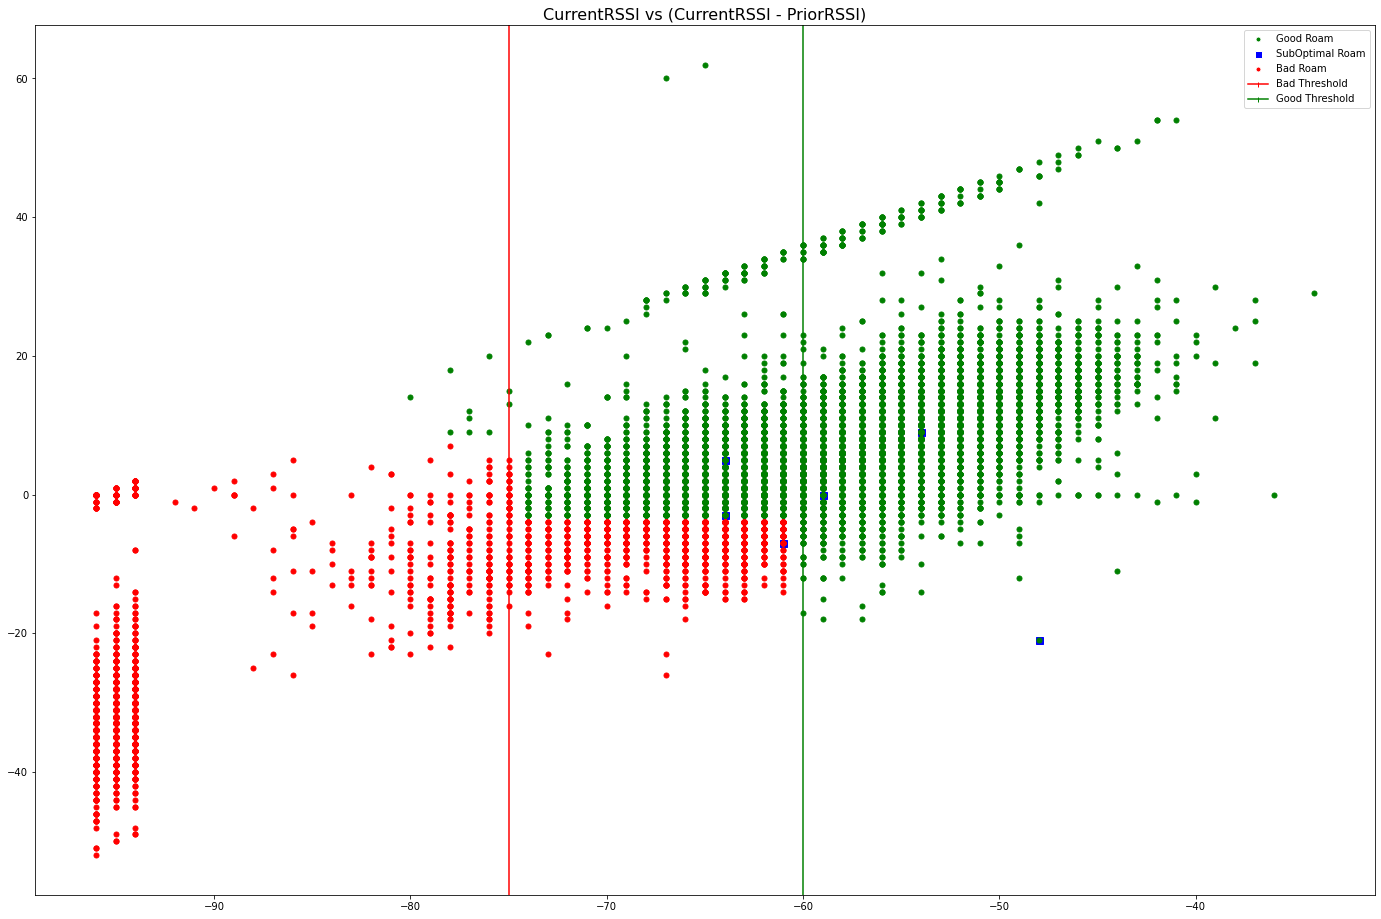

In [18]:
%matplotlib inline

#
# scatter plot good and bad roaming events along with instances of SunOptimalRoam
#
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import math

GOOD_THRESHOLD=-60
BAD_THRESHOLD=-75

f = plt.figure()
f.set_figwidth(24)
f.set_figheight(16)
print(sdf.shape[0])
for i in range(sdf.shape[0]):
    x=sdf.iloc[i,13]
    y=sdf.iloc[i,14]
    
    quality = sdf.iloc[i,0]
    classifier = sdf.iloc[i,1]
    
    if( quality == "Good"):
        if( classifier == "RoamedToSubOptimalAP"):
            plt.plot(y, y-x, 'bs', markersize=7)
        plt.plot(y,y-x, "go", markersize=5)
    else:
        plt.plot(y,y-x, "ro", markersize=5)
        if( classifier == "RoamedToSubOptimalAP"):
            plt.plot(y, y-x, 'bs', markersize=7) 

plt.axvline(x=GOOD_THRESHOLD, color='g')
plt.axvline(x=BAD_THRESHOLD, color='r')

plt.title("CurrentRSSI vs (CurrentRSSI - PriorRSSI)", fontsize=16)

legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Good Roam', markerfacecolor='g', markersize=5),
                    Line2D([0], [0], marker='s', color='w', label='SubOptimal Roam', markerfacecolor='b', markersize=7),
                    Line2D([0], [0], marker='o', color='w', label='Bad Roam', markerfacecolor='r', markersize=5),
                    Line2D([0], [0], marker='|', color='r', label='Bad Threshold', markerfacecolor='r', markersize=5),
                    Line2D([0], [0], marker='|', color='g', label='Good Threshold', markerfacecolor='g', markersize=5),
                  ]

# Create the figure
plt.legend(handles=legend_elements, loc='best')
plt.show()